In [1]:
import pandas
from datetime import datetime, timedelta
import time

In [2]:
import pickle

In [49]:
from sklearn.externals import joblib

In [33]:
import numpy

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score

In [4]:
chats = pandas.read_csv("train\\chats_train.csv").sort_values('timestamp')

In [5]:
news = pandas.read_csv("train\\news_train.csv")
onchain_EOS = pandas.read_csv("train\\onchain\\EOS_train.csv")
onchain_TRX = pandas.read_csv("train\\onchain\\TRX_train.csv")
prices = pandas.read_csv("train\\tickers_train.csv")

In [229]:
ticker = 'DRGN'
delta = timedelta(minutes=10)

In [230]:
#Найдем максимальную и минимальную даты в файле с ценами
min_date = datetime.today()
max_date = datetime.fromordinal(1)
# отфильтруем price по нашему токену и отсортируем по времени
tic_prices = prices.loc[prices['ticker']==ticker].sort_values('datetime',ascending=True)

In [231]:
for line in tic_prices['datetime']:
    curtime = datetime.strptime(line,"%Y-%m-%dT%H:%M:%SZ")
    if curtime > max_date:
        max_date = curtime
    if curtime < min_date:
        min_date = curtime

In [232]:
print(min_date, max_date)

2018-03-01 00:00:00 2018-04-30 22:00:00


In [148]:
max_messages = 0
chats_index = 0
cur_chats_counter = 0
#Пропустим все тексты, которые появились раньше, чем за 2 часа до первой котировки
first_text_timestamp = datetime.timestamp(min_date - delta) 
while chats.iloc[chats_index]['timestamp'] < first_text_timestamp:
    chats_index = chats_index + 1
print(chats_index)
cur_day = min_date.day
cur_chats = []
cur_news = []
cur_date = min_date
X_raw = []
X = []
while cur_date <= max_date:
    while (chats.iloc[chats_index]['timestamp'] < datetime.timestamp(cur_date)):
        if chats.iloc[chats_index]['sender_is_bot']:            
            chats_index = chats_index + 1
            continue
        cur_chats.append(chats.iloc[chats_index][['chat_id', 'chat_title', 'emoji_list', 'sender_first_name', 'sender_id',
       'sender_is_bot', 'sender_last_name', 'sender_username', 'text']])
        chats_index = chats_index + 1
        cur_chats_counter = cur_chats_counter + 1
        
        #if cur_chats_counter > 200:
            #break
    if max_messages < cur_chats_counter:
        print(cur_chats_counter, cur_date)
        max_messages = cur_chats_counter
    X_raw.append(cur_chats.copy())
    cur_chats = []
    cur_chats_counter = 0
    cur_date = cur_date + delta


0
288 2018-03-01 00:10:00
447 2018-03-01 00:20:00
543 2018-03-01 00:30:00
648 2018-03-07 18:50:00
901 2018-03-07 19:40:00
953 2018-03-07 20:00:00
1018 2018-03-07 20:30:00
1068 2018-04-12 14:30:00
1077 2018-04-12 14:40:00
1519 2018-04-17 15:50:00
1694 2018-04-17 16:00:00
2953 2018-04-17 17:00:00
3533 2018-04-17 17:10:00


In [228]:
def calc_Y(tic):
    Y = []
    Y_count = [0,0,0]
    price_index = 0
    cur_date = min_date
    tic_prices = prices.loc[prices['ticker']==tic].sort_values('datetime',ascending=True)
    last_price = tic_prices['priceBtc'].iloc[0]
    search_index = 0
    search_step = 4
    search_width = thresholds[tic]
    print('threshold: ', search_width)
    while cur_date <= max_date:
        cur_price = tic_prices.iloc[price_index]['priceBtc']
        cur_y = 0
        for i in range(search_step):
            if price_index + i + 1 < tic_prices.shape[0]:
                new_price = tic_prices.iloc[price_index + i + 1]['priceBtc']
                if new_price > cur_price*(1 + search_width):
                    cur_y = 1
                    break
                elif new_price < cur_price*(1 - search_width):
                    cur_y = 2
                    break
        if price_index + 1 < tic_prices.shape[0]:
            next_price_date = datetime.strptime(tic_prices.iloc[price_index + 1]['datetime'],"%Y-%m-%dT%H:%M:%SZ")
            while cur_date < next_price_date: 
                Y.append(cur_y)
                cur_date = cur_date + delta
                Y_count[cur_y] += 1
        else:
            break
        price_index = price_index + 1
        #print(price_index, cur_date)

    Y_count[0] += 1
    Y.append(0)
    print(Y_count, sum(Y_count), len(Y))
    return Y

In [155]:
X = []
for cur_X in X_raw:
    cur_str = ''
    for message in cur_X:
        cur_str = cur_str + str(message['text']) + ' '
    X.append(cur_str)

In [156]:
len(X)

8773

In [162]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=40, stratify=Y)
x_train = X[:7999]
x_test = X[8000:]



In [163]:
y_train = Y[:7999]
y_test = Y[8000:]
print(len(x_train), len(x_test), len(y_train), len(y_test))

7999 773 7999 773


In [182]:
vectorizer_char = TfidfVectorizer(max_features=40000,
                             min_df=50, 
                             max_df=0.5, 
                             analyzer='char', 
                             ngram_range=(1, 4))

vectorizer_char.fit(x_train);

tfidf_matrix_char_train = vectorizer_char.transform(x_train)
tfidf_matrix_char_test = vectorizer_char.transform(x_test)

lr_char = LogisticRegression(solver='sag', verbose=2, multi_class='multinomial')
#lr_char = RandomForestClassifier()



In [184]:
lr_char = LogisticRegression(solver='sag', verbose=2, multi_class='multinomial', max_iter = 500)
lr_char.fit(tfidf_matrix_char_train, y_train)

y_pred_char = lr_char.predict(tfidf_matrix_char_test)
print(accuracy_score(y_test, y_pred_char))
y_pred_train = lr_char.predict(tfidf_matrix_char_train)
print(accuracy_score(y_train, y_pred_train))

convergence after 21 epochs took 11 seconds
0.40620957309184996
0.8542317789723716


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s finished


In [198]:
vectorizer_word = TfidfVectorizer(max_features=40000,
                             min_df=20, 
                             max_df=0.5, 
                             analyzer='word',
                             stop_words = 'english',     
                             ngram_range=(1, 2))

vectorizer_word.fit(x_train);

In [199]:
tfidf_matrix_word_train = vectorizer_word.transform(x_train)
tfidf_matrix_word_test = vectorizer_word.transform(x_test)

In [200]:
lr_word = LogisticRegression(solver='sag', verbose=2, multi_class='multinomial', max_iter = 500)
lr_word.fit(tfidf_matrix_word_train, y_train)

y_pred_word = lr_word.predict(tfidf_matrix_word_test)
print(accuracy_score(y_test, y_pred_word))
y_pred_train = lr_word.predict(tfidf_matrix_word_train)
print(accuracy_score(y_train, y_pred_train))

convergence after 19 epochs took 3 seconds
0.3777490297542044
0.9032379047380923


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


In [219]:
def print_acc():
    acc_word = [0,0,0]
    acc_char = [0,0,0]
    acc2_word = [0,0]
    acc2_char = [0,0]
    for i in range (len(y_test)):
        if y_test[i] == y_pred_word[i]:
            acc_word[y_pred_word[i]] = acc_word[y_pred_word[i]] + 1
        if y_test[i] == y_pred_char[i]:
            acc_char[y_pred_char[i]] = acc_char[y_pred_char[i]] + 1
        if y_test[i] != 0:
            if y_pred_word[i] != 0:
                if y_test[i] == y_pred_word[i]:
                    acc2_word[0] = acc2_word[0] + 1
                else:
                    acc2_word[1] = acc2_word[1] + 1
            if y_pred_char[i] != 0:
                if y_test[i] == y_pred_char[i]:
                    acc2_char[0] = acc2_char[0] + 1
                else:
                    acc2_char[1] = acc2_char[1] + 1

    print(acc_word, acc2_word, len(y_test))
    print(acc_char, acc2_char, len(y_test))

In [53]:
tfidf_matrix_char_X = vectorizer_char.transform(X)

In [50]:
joblib.dump(vectorizer_char, 'vectorizer_char.pkl') 

['vectorizer_char.pkl']

In [55]:
joblib.dump(tfidf_matrix_char_X, 'tfidf_matrix_char_X.pkl') 

['tfidf_matrix_char_X.pkl']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=40, stratify=Y)
print(len(x_train), len(x_test), len(y_train), len(y_test))

658 74 658 74


In [278]:
f_names_word = vectorizer_word.get_feature_names()
f_names_char = vectorizer_char.get_feature_names()
tic_list_word = dict()
tic_list_char = dict()

for tic in tickers:
    tic_list_word[tic] = dict()
    tic_list_char[tic] = dict()

    print(tic)
    Y = calc_Y(tic)
    y_train = Y[:7999]
    y_test = Y[8000:]
    lr_char.fit(tfidf_matrix_char_train, y_train)
    print('CHAR')
    y_pred_char = lr_char.predict(tfidf_matrix_char_test)
    print(accuracy_score(y_test, y_pred_char))
    y_pred_train = lr_char.predict(tfidf_matrix_char_train)
    print(accuracy_score(y_train, y_pred_train))
    
    lr_word.fit(tfidf_matrix_word_train, y_train)
    print('WORD')
    y_pred_word = lr_word.predict(tfidf_matrix_word_test)
    print(accuracy_score(y_test, y_pred_word))
    y_pred_train = lr_word.predict(tfidf_matrix_word_train)
    print(accuracy_score(y_train, y_pred_train)) 
    print_acc()
    for i in range(40000):
        take_i = False
        for j in [0,1,2]:
            if abs(lr_word.coef_[j,i]) > 0.5:
                take_i = True
        if take_i:
            tic_list_word[tic][f_names_word[i]] = lr_word.coef_[:,i].copy()    
        take_i = False
        for j in [0,1,2]:
            if abs(lr_char.coef_[j,i]) > 0.5:
                take_i = True
        if take_i:
            tic_list_char[tic][f_names_char[i]] = lr_char.coef_[:,i].copy() 


DRGN
threshold:  0.035
[5509, 1560, 1704] 8773 8773
convergence after 23 epochs took 31 seconds
CHAR
0.5886157826649417


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.0s finished


0.7984748093511689
convergence after 25 epochs took 7 seconds
WORD
0.630012936610608
0.8342292786598324
[479, 0, 8] [8, 16] 773
[446, 0, 9] [9, 18] 773
EOS


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s finished


threshold:  0.025
[5425, 1944, 1404] 8773 8773
convergence after 23 epochs took 30 seconds
CHAR
0.33635187580853815


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.9s finished


0.8033504188023503
convergence after 22 epochs took 6 seconds
WORD
0.3298835705045278
0.8302287785973247
[175, 80, 0] [80, 29] 773
[193, 65, 2] [67, 34] 773


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished


ZRX
threshold:  0.025
[4573, 2208, 1992] 8773 8773
convergence after 25 epochs took 33 seconds
CHAR
0.4294954721862872


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s finished


0.82560320040005
convergence after 22 epochs took 7 seconds
WORD
0.425614489003881
0.8778597324665584
[288, 5, 36] [41, 50] 773
[286, 7, 39] [46, 46] 773


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


TRX
threshold:  0.02
[4261, 2616, 1896] 8773 8773
convergence after 24 epochs took 31 seconds
CHAR
0.40620957309184996


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.3s finished


0.8541067633454181
convergence after 22 epochs took 6 seconds
WORD
0.3777490297542044
0.9032379047380923
[113, 178, 1] [179, 59] 773
[138, 166, 10] [176, 75] 773
ETH


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


threshold:  0.01
[4225, 2112, 2436] 8773 8773
convergence after 22 epochs took 29 seconds
CHAR
0.35575679172056923


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.9s finished


0.8637329666208277
convergence after 23 epochs took 7 seconds
WORD
0.3117723156532988
0.9217402175271909
[149, 50, 42] [92, 94] 773
[200, 42, 33] [75, 81] 773


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished


ETC
threshold:  0.015
[4429, 1884, 2460] 8773 8773
convergence after 22 epochs took 30 seconds
CHAR
0.3428201811125485


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.2s finished


0.852356544568071
convergence after 22 epochs took 6 seconds
WORD
0.34799482535575677
0.8926115764470559
[197, 29, 43] [72, 75] 773
[198, 18, 49] [67, 73] 773
BCH

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished



threshold:  0.015
[5461, 1608, 1704] 8773 8773
convergence after 23 epochs took 28 seconds
CHAR
0.34670116429495473


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s finished


0.8173521690211276
convergence after 21 epochs took 5 seconds
WORD
0.32729624838292365
0.8389798724840605
[164, 47, 42] [89, 87] 773
[185, 44, 39] [83, 72] 773
LTC

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished



threshold:  0.01
[4669, 1956, 2148] 8773 8773
convergence after 22 epochs took 28 seconds
CHAR
0.6119016817593791


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.9s finished


0.8437304663082885
convergence after 22 epochs took 5 seconds
WORD
0.6442432082794308
0.8989873734216777
[477, 2, 19] [21, 11] 773
[446, 3, 24] [27, 10] 773


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


In [279]:
tickers = ['DRGN','EOS','ZRX','TRX','ETH','ETC','BCH','LTC']
thresholds = {'DRGN':0.035, 'EOS':0.025, 'ZRX':0.025,'TRX':0.02,'ETH':0.01,'ETC':0.015,'BCH':0.015,'LTC':0.01}

In [281]:
freq_words = dict()
for tic in tic_list_word:
    for word in tic_list_word[tic]:
        if word in freq_words:
            freq_words[word] += 1
        else:
            freq_words[word] = 1

In [282]:
freq_chars = dict()
for tic in tic_list_char:
    for word in tic_list_char[tic]:
        if word in freq_chars:
            freq_chars[word] += 1
        else:
            freq_chars[word] = 1

In [283]:
for word in freq_chars:
    if (word in tic_list_char['TRX']) and (word in tic_list_char['EOS']) :
        print(word, freq_chars[word],  tic_list_char['TRX'][word], tic_list_char['EOS'][word])

 /t 8 [-0.16775316  0.98935661 -0.82160346] [-0.00125305  1.21813962 -1.21688657]
 api 7 [ 0.49773375 -0.64128414  0.14355039] [ 0.59508745 -0.39969558 -0.19539187]
 cdt 4 [-0.4383305  -0.34670431  0.78503481] [ 0.81329957 -0.54639997 -0.2668996 ]
 dn 5 [ 0.28458577 -0.58259443  0.29800867] [ 0.66984711 -0.31625621 -0.3535909 ]
 dnt 8 [ 0.47024103 -0.94853942  0.4782984 ] [ 0.98865961 -0.66738027 -0.32127934]
 g2 6 [-0.75093636  0.83128951 -0.08035315] [-0.73935993  0.43571133  0.3036486 ]
 g20 6 [-0.77046675  0.81868688 -0.04822013] [-0.77902727  0.43673685  0.34229041]
 hac 6 [ 0.71583198 -0.58455928 -0.1312727 ] [ 0.46007827  0.04009366 -0.50017193]
 icx 5 [-0.80611499  0.35589894  0.45021605] [-0.54543986  0.56217661 -0.01673675]
 pac 8 [-0.54903825  0.90970745 -0.36066919] [-0.89937933  1.19267551 -0.29329618]
 por 7 [-0.51771583  0.55772802 -0.04001218] [ 1.02838754 -0.41659087 -0.61179668]
 qt 6 [-0.6770529  0.2549825  0.4220704] [-0.95038495  0.5873096   0.36307535]
 qtu 7 [-0.

In [286]:
inter_chars = ['❗','👇','👇👇','😅','😑', '谢', '💋', '🚀🚀','🚀']

In [289]:
freq_chars[inter_chars[2]]

5

In [285]:
for word in freq_words:
    if (word in tic_list_word['EOS']) and (word in tic_list_word['TRX']):
        print(word, freq_words[word], tic_list_word['EOS'][word], tic_list_word['TRX'][word])

1000 6 [-0.53236165  0.4445299   0.08783175] [ 0.10648134 -0.63175031  0.52526896]
1000 ont 5 [-0.76865055  0.56836384  0.20028671] [-0.67943852  0.10868042  0.57075811]
11 5 [ 0.68999236 -0.58220716 -0.1077852 ] [-0.77557263  0.9417957  -0.16622308]
16th 6 [-0.72617412  1.00800201 -0.28182789] [ 0.5536175  -0.43158096 -0.12203655]
17 5 [ 0.51773721 -0.16752764 -0.35020958] [ 0.33718459 -0.56034067  0.22315608]
18t 7 [-1.06957418  1.65117252 -0.58159834] [-0.44177843  0.93527876 -0.49350033]
19 7 [-0.6154019   0.91094443 -0.29554254] [ 0.62464074 -0.33252742 -0.29211332]
20k 4 [ 0.61577827 -0.27001193 -0.34576634] [ 0.15722068 -0.5026879   0.34546721]
24 3 [-0.69608638  0.55369834  0.14238804] [-0.6798727   0.61178135  0.06809135]
2fa 5 [ 0.46019819 -0.56205199  0.1018538 ] [ 0.97113492 -0.41423216 -0.55690277]
5d 3 [-0.50290302  0.60239966 -0.09949663] [-0.50183523  0.89280212 -0.39096688]
600 5 [ 0.4138951   0.26895018 -0.68284527] [-0.49422547 -0.03716947  0.53139494]
6k 5 [ 0.53613

green 4 [-0.60539668  0.0767238   0.52867288] [-0.34041547  0.64360211 -0.30318664]
https makemoney23 5 [-0.88212879  0.76228016  0.11984863] [-0.07418869  0.51463834 -0.44044965]
https teampumpsignalscommunityone 5 [-0.17148212  0.51607148 -0.34458936] [ 0.56143301 -0.39498961 -0.1664434 ]
huobi 5 [ 0.35690778 -0.5057353   0.14882752] [-1.00663961  0.85850746  0.14813214]
ins 4 [-0.2623436  -0.34830532  0.61064891] [-0.39541658  0.69228725 -0.29687067]
japan 7 [-1.04170361  1.30888095 -0.26717733] [-0.43905834  1.05743122 -0.61837288]
jez 5 [-0.76824226  0.43266565  0.33557661] [-1.36111567  1.50643357 -0.1453179 ]
june 3 [ 0.45267641 -0.76562558  0.31294916] [ 0.2707112   0.28533439 -0.55604559]
kucoin 6 [ 0.65042223 -0.08534817 -0.56507406] [ 0.27045099  0.37364634 -0.64409733]
kybertrackerbot 5 [-0.57200033  0.45197331  0.12002702] [-0.551109    0.18449694  0.36661206]
listed 5 [-0.62686472  0.53385835  0.09300636] [ 0.23900176  0.62084189 -0.85984365]
makemoney23 5 [-0.88212879  0

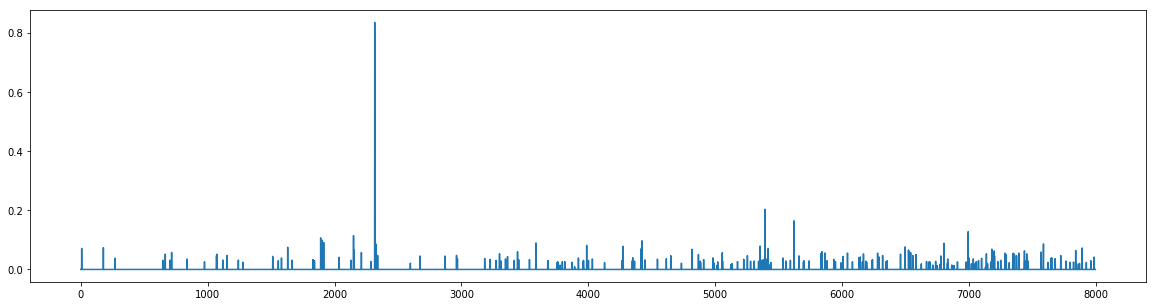

In [311]:
draw_graph('985689243379949568')

In [290]:
inter_words = ['985689243379949568','answer','api','april fools','balance','balance issue','bloomberg','bounce','buy buy','candle',
              'careful','check ticket','clo','coinbase','competition','correction','dent','dominance','donate','dumping',
              'easter','ela','flipkart','g20','giveaway','got 1000','grs','hacked','hackers','ico price','india','korean','kyber',
               'malta','mana','mda','morning','neon','nikkei','ocn','otc','pac','paccoin','partnership','pump pump','qlc','qtum',
               'rbi','sale','security','storm','sunday','target','target target','trx tron','video','yesterday','zil','谢谢','1024 trx',
              '15th april','2013','24 hours','400','5050','analysis','bart','bithumb','bittrex','bleed','cardano','charles','chinese',
              'contest','cs_1002','did donate','donation','fsb','fuel','fun','gox','mt gox','mt','makemoney23','japan',
               'margin trading','market going','omg','order','parkgene official','read pinned','refunds','regulation','sell sell',
              'shitcoin','sonm','statement','technology','whitelist','wpr','youtube']

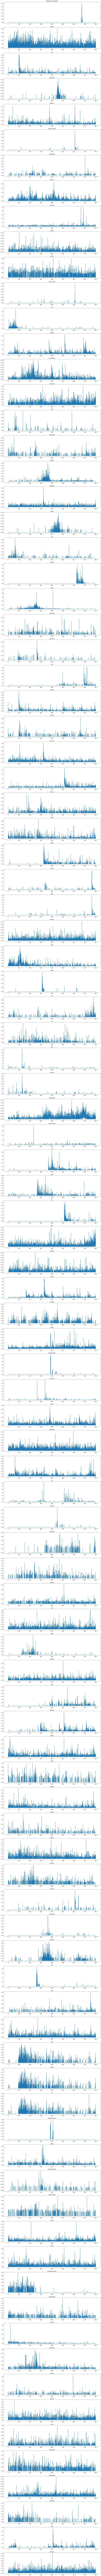

In [317]:
rows = 101
cols = 1
fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize =(20,550))
plt_X = range(pandas.DataFrame(tfidf_matrix_word_train[:,my_num].toarray()).shape[0])
plt_Y = pandas.DataFrame(tfidf_matrix_word_train[:,my_num].toarray()).values
i = 0
for my_w in inter_words:
    my_num = f_names_word.index(my_w)
    plt_X = range(pandas.DataFrame(tfidf_matrix_word_train[:,my_num].toarray()).shape[0])
    plt_Y = pandas.DataFrame(tfidf_matrix_word_train[:,my_num].toarray()).values
    axes[i].plot(plt_X,plt_Y)
    axes[i].set_title(my_w)
    i += 1

In [ ]:
with open('X_raw.pickle', 'wb') as handle:
    pickle.dump(X_raw, handle, protocol=4)

In [99]:
with open('XY_train_XY_test.pickle', 'wb') as handle:
    pickle.dump([tfidf_matrix_char_train,tfidf_matrix_char_test, y_train, y_test ], handle, protocol=2)

In [303]:
from matplotlib import pyplot as plt
%matplotlib inline

In [293]:
f_names_word.index('g20')

13707

In [313]:
def draw_graph(my_word):
    rows = 1
    cols = 1
    fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize =(20,5))
    plt_X = range(pandas.DataFrame(tfidf_matrix_word_train[:,my_num].toarray()).shape[0])
    plt_Y = pandas.DataFrame(tfidf_matrix_word_train[:,my_num].toarray()).values
    
    axes.plot(plt_X,plt_Y)
    axes.set_title(my_word)